# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re

 # Provisioning

## 1.Importing Dataset

Using glob we scan the directory of a local folder, getting all files in the process. Using regex we filter out any file type that isn't .csv. We name all files apropriately, read the file and cast them to the appropriate variables. 

In [2]:
## Find all .csv in specified directory
# directory path
dir = r"project_datasets\\"
# glob finds and puts all the file paths into a list
all_files = glob.glob(dir + "*.csv")

In [3]:
## Using RegEx take the name and format it (Format => "df_A")
pattern = re.compile(r'(?<=\\)(.*?)(?=\.)')
def get_file_names(x):
    files = x
    saved = []
    for file in files:
        for name in re.findall(pattern, file):
            name = name.replace("data","df")
            ## .lower() could be removed it's just that our existing document uses lower case (df_a, df_d)
            name = name.lower()
            saved.append(name)
    return saved

In [4]:
## Read all the file name and paths and assign them to variable
dataframe_names = get_file_names(all_files)
for index, item in enumerate(dataframe_names):
    globals()['%s' % item] = pd.read_csv(all_files[index])

In [5]:
print("Available Dataframes:")
print(dataframe_names)

Available Dataframes:
['df_a', 'df_aa', 'df_ab', 'df_ac', 'df_ad', 'df_b', 'df_c', 'df_d', 'df_e', 'df_f', 'df_g', 'df_h', 'df_i', 'df_j', 'df_k', 'df_m', 'df_n', 'df_o', 'df_p', 'df_q', 'df_r', 'df_s', 'df_t', 'df_u', 'df_v', 'df_w', 'df_x', 'df_y', 'df_z']


## 2.Converting our dataframes to Time Series

We convert the EventDt column in each avaiable dataframe to DateTime format, after which we set it as an index and then we resmaple the data on a 5 minute frequency.
Addtionally we add a daily, weekly and monthly variant of each dataframe that assist us in the data analysis at a later point in this notebook.

In [6]:
## Convert all column types to date_time and transform dataframes to time-series
for item in dataframe_names:
    globals()['%s' % item]["EventDt"] = pd.to_datetime(globals()['%s' % item]["EventDt"])
    globals()['%s' % item] = globals()['%s' % item].set_index(globals()['%s' % item]["EventDt"])
    globals()['%s' % item] = globals()['%s' % item].resample(rule="5T").mean()

In [7]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315647 entries, 2018-11-18 16:10:00 to 2021-11-18 16:00:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    258390 non-null  float64
dtypes: float64(1)
memory usage: 4.8 MB


In [8]:
## Added additional dataframes with resampled data in different formats (daily, weekly, monthly)
for item in dataframe_names:
    globals()['%s_daily' % item] = globals()['%s' % item].resample(rule="D").mean()
    globals()['%s_weekly' % item] = globals()['%s' % item].resample(rule="W").mean()
    globals()['%s_monthly' % item] = globals()['%s' % item].resample(rule="M").mean()

## 3. Visualisation 

Before we went any farther with our research, we wanted to see what each gadget was doing and if it was being read correctly.

Text(0.5, 1.0, 'Linear graph')

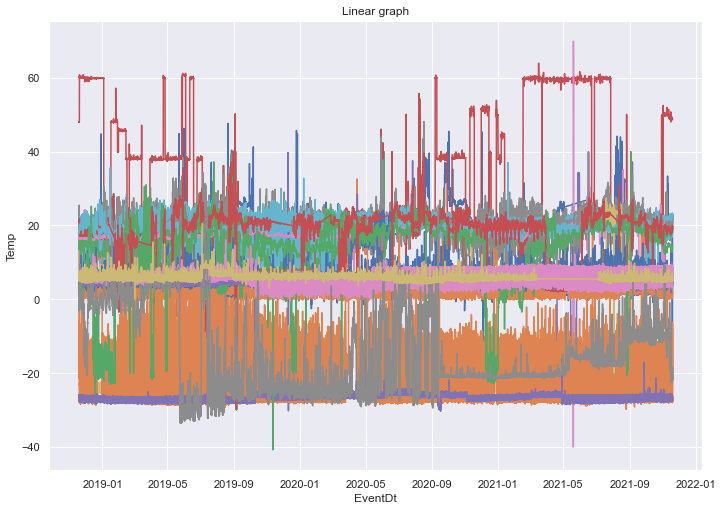

In [9]:
#pic size
sns.set(rc={'figure.figsize':(11.7,8.27)})
#fix the date and maybe zoom in or smt
fig, ax = plt.subplots()
sns.lineplot(x='EventDt', y='Temp', data=df_a, ax=ax) #first dataset
sns.lineplot(x='EventDt', y='Temp', data=df_aa, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_ab, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_ac, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_ad, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_b, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_c, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_d, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_e, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_f, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_g, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_h, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_i, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_j, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_k, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_m, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_n, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_o, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_p, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_q, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_r, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_s, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_t, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_u, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_v, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_w, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_x, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_y, ax=ax)
sns.lineplot(x='EventDt', y='Temp', data=df_z, ax=ax)
plt.title("Linear graph")

As can be observed, the representation of each sensor is a jumble, making it difficult to understand what is going on within. To approach the analysis through this research, we will first compile average temperatures for each device to evaluate where they stand from freezing to warming.

## 4.Average Temperature Dictionary

To cut-down on load times, instead of plotting each dataframe values directly, we create a dictionary with the names and average temperature for each of our devices. Said dictionary is later plotted using SeaBorn barplot.

In [10]:
average_temps = []
for item in dataframe_names:
#     mean_temp = globals()['%s' % item]["Temp"].mean()
    mean_temp = globals()['%s' % item]["Temp"].quantile(.35)
    average_temps.append(mean_temp)
    
mean_temp_dev_dictionary = {"Device":dataframe_names,"Mean Temperature":average_temps}
mean_temp_dev = pd.DataFrame.from_dict(mean_temp_dev_dictionary)
mean_temp_dev.T

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
Device,df_a,df_aa,df_ab,df_ac,df_ad,df_b,df_c,df_d,df_e,df_f,...,df_q,df_r,df_s,df_t,df_u,df_v,df_w,df_x,df_y,df_z
Mean Temperature,17.33,-21.0,18.83,21.87,19.41,5.55,14.15,16.84,-24.13,21.75,...,18.89,4.53,0.96,13.0,19.53,4.14,6.36,5.19,-21.1,5.54


We opted to approach it through visuals from the coldest to the warmest temperature per device to see where each of the standing and categorize it after the average temperature conversion.

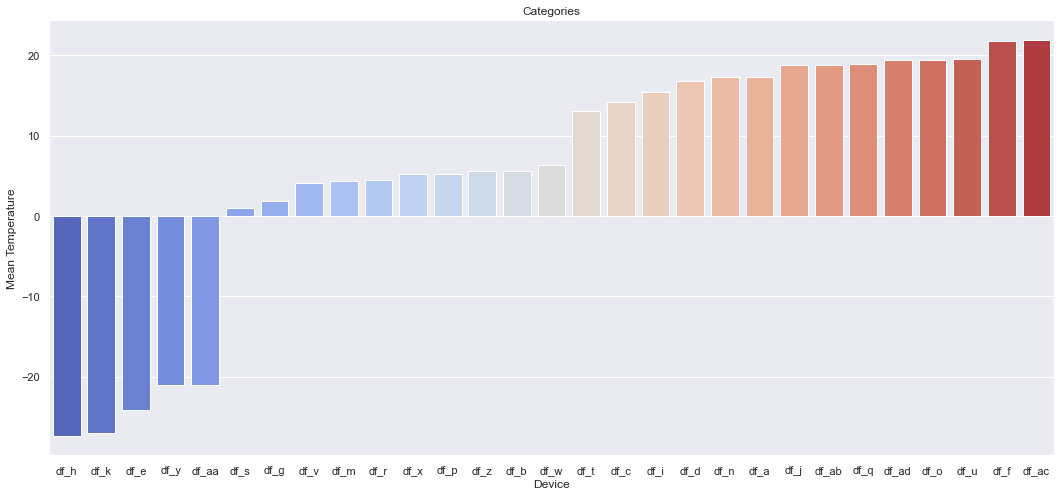

In [11]:
#sns.set_theme(style="whitegrid")
#sns.set_palette(sns.color_pallete("icefire"),as_cmap=True)
sns.set(rc={'figure.figsize':(18,8)})
sns.barplot(x="Device", 
            y="Mean Temperature", 
            data=mean_temp_dev,
            order=mean_temp_dev.sort_values('Mean Temperature').Device,
            palette = "coolwarm").set(title='Categories')
plt.show()

After plotting the dictionary we can easily see the average temperature for each dataframe and compare them to one another. This will help us with categorizing and labeling our dataframes.

## 5.Categorizing Dataframes

After careful consideration and discussion we decided to seperate our dataframes into three distinct categories: Freezer, Fridge, Pantry

In [12]:
#barchart per category
#check the order
mean_temp_dev.sort_values(by='Mean Temperature',ascending=True).T

,11,14,8,27,1,21,10,24,15,20,...,16,0,13,2,19,4,17,23,9,3
Device,df_h,df_k,df_e,df_y,df_aa,df_s,df_g,df_v,df_m,df_r,...,df_n,df_a,df_j,df_ab,df_q,df_ad,df_o,df_u,df_f,df_ac
Mean Temperature,-27.33,-26.97,-24.13,-21.1,-21.0,0.96,1.91,4.14,4.37,4.53,...,17.24,17.33,18.83,18.83,18.89,19.41,19.43,19.53,21.75,21.87


In [13]:
#categories
categories = []
for value in mean_temp_dev['Mean Temperature']:
    if value < 0: categories.append('Freezer')
    elif 0 <= value < 10: categories.append('Fridge')
    elif 10 <= value :categories.append('Pantry')
    else: categories.append('unknown')
        
mean_temp_dev['Categories']  = categories
mean_temp_dev.T

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
Device,df_a,df_aa,df_ab,df_ac,df_ad,df_b,df_c,df_d,df_e,df_f,...,df_q,df_r,df_s,df_t,df_u,df_v,df_w,df_x,df_y,df_z
Mean Temperature,17.33,-21.0,18.83,21.87,19.41,5.55,14.15,16.84,-24.13,21.75,...,18.89,4.53,0.96,13.0,19.53,4.14,6.36,5.19,-21.1,5.54
Categories,Pantry,Freezer,Pantry,Pantry,Pantry,Fridge,Pantry,Pantry,Freezer,Pantry,...,Pantry,Fridge,Fridge,Pantry,Pantry,Fridge,Fridge,Fridge,Freezer,Fridge


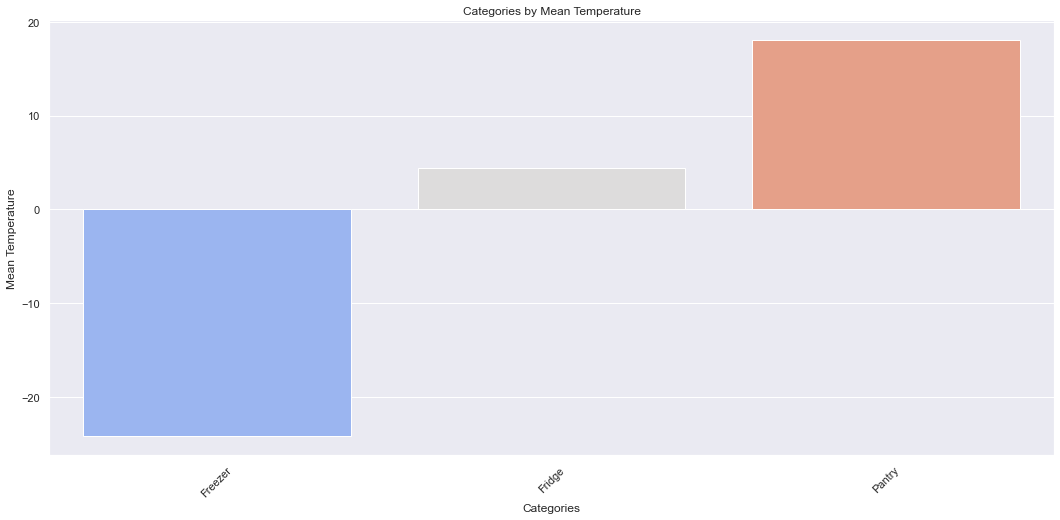

In [14]:
#barchart per group
sns.barplot(data=mean_temp_dev,
                x="Categories",
                y="Mean Temperature",
                palette = "coolwarm",
                ci=None,
                order=["Freezer", "Fridge","Pantry"])
plt.title('Categories by Mean Temperature')
plt.xticks(rotation=45)
plt.show()

As can be seen, each gadget was assigned to one of three groups:
- ``Freezer``: devices with tempreture lower than 0 
- ``Fridge``: devices with tempreture higher than 0, but lower than 10
- ``Pantry``: devices with tempreture higher than 10

Because the data does not contain any labeling, such categorization is an obvious technique taken by group memebers through the usage of external resources.

Following the categorization of the devices, we want to observe each device's pattern through a line plot, which will allow us to approach any potential anomalies and subsequently approach the selection of view devices to make the research more comfortable.

# Visuallization By Category

Here we plot every dataframe divided based on category from which we will pick the most apropriate dataset to train our model on. In order for dataframe to be deemed apropriate for further analysis it needs to fufill the following conditions:
- Data Consistency
- None or very little missing values
- Upper and lower alarm threshold (Optional)

## Freezer Category

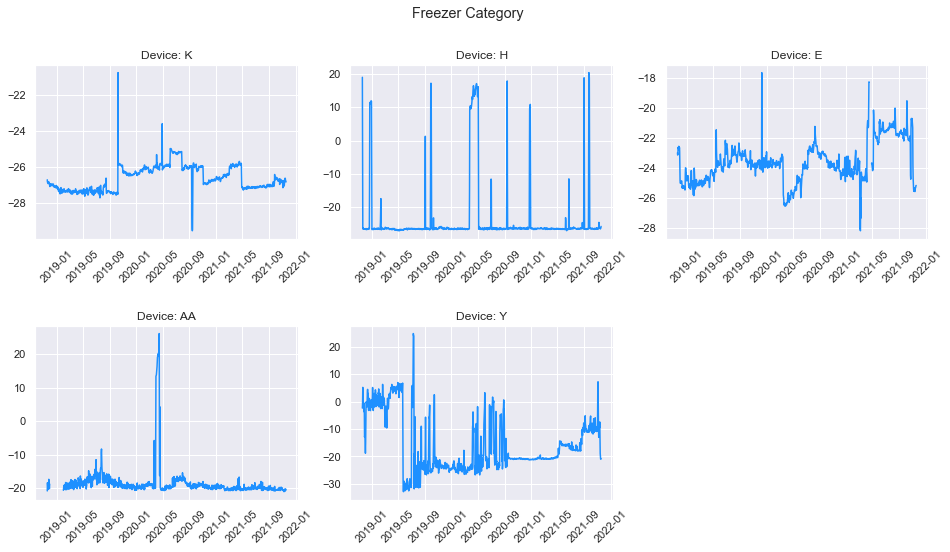

In [15]:
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Freezer Category')
# Height Margin
plt.subplots_adjust(hspace=0.5)
#plot 1
fig.add_subplot(2,3,1)
plt.plot(df_k_daily["Temp"],color='dodgerblue')
plt.title('Device: K')
plt.xticks(rotation=45)
#fig.autofmt_xdate()

#plot 2
plt.subplot(2,3,2)
plt.plot(df_h_daily["Temp"],color='dodgerblue')
plt.title('Device: H')
plt.xticks(rotation=45)

#plot 3
plt.subplot(2,3,3)
plt.plot(df_e_daily["Temp"],color='dodgerblue')
plt.title('Device: E')
plt.xticks(rotation=45)

#plot 4
plt.subplot(2,3,4)
plt.plot(df_aa_daily["Temp"],color='dodgerblue')
plt.title('Device: AA')
plt.xticks(rotation=45)

#plot 5
plt.subplot(2,3,5)
plt.plot(df_y_daily["Temp"],color='dodgerblue')
plt.title('Device: Y')
plt.xticks(rotation=45)
plt.show()

As can be seen, there are 5 devices in the freezer category, all of which detect a small number of anomalies and appear to be consistent in their patterns; however, with so many devices, it will be difficult to approach an analysis for all of them; therefore, to limit our research, we will cut out E and Y devices due to their unprogized prattens that could complicate the modeling, and we will leave them out.

## Fridge Category

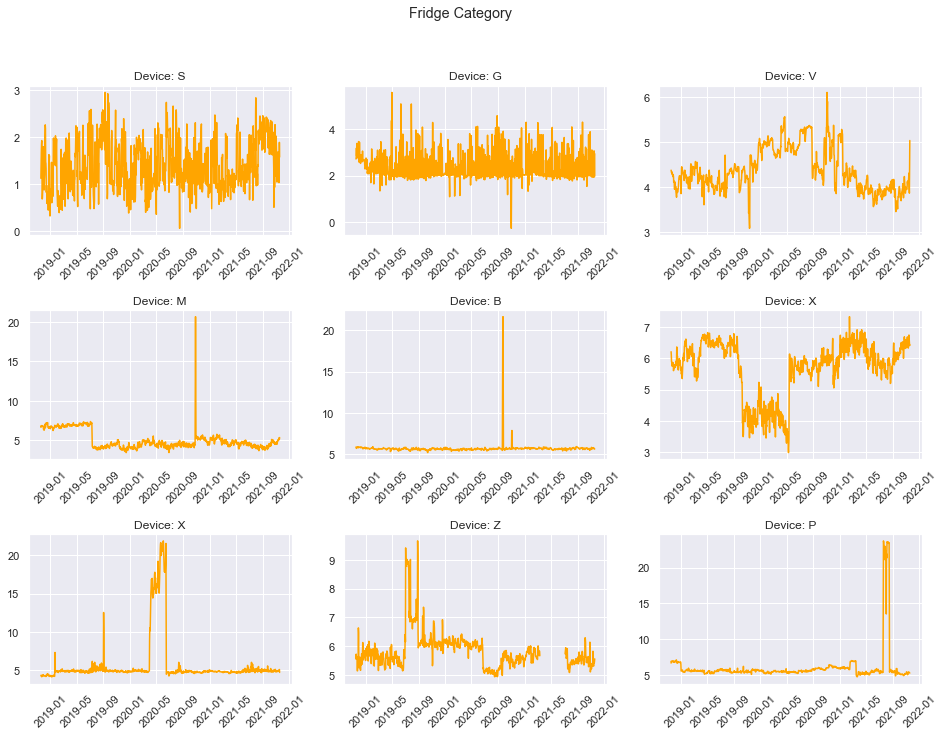

In [16]:
#pic size
fig = plt.figure(figsize=(16, 11))
fig.suptitle('Fridge Category')
# Height Margin
plt.subplots_adjust(hspace=0.5)

#plot 1
fig.add_subplot(3,3,1)
plt.plot(df_s_daily["Temp"],color='orange')
plt.title('Device: S')
plt.xticks(rotation=45)

#plot 2
plt.subplot(3,3,2)
plt.plot(df_g_daily["Temp"],color='orange')
plt.title('Device: G')
plt.xticks(rotation=45)

#plot 3
plt.subplot(3,3,3)
plt.plot(df_v_daily["Temp"],color='orange')
plt.title('Device: V')
plt.xticks(rotation=45)

#plot 4
plt.subplot(3,3,4)
plt.plot(df_m_daily["Temp"],color='orange')
plt.title('Device: M')
plt.xticks(rotation=45)

#plot 5
plt.subplot(3,3,5)
plt.plot(df_b_daily["Temp"],color='orange')
plt.title('Device: B')
plt.xticks(rotation=45)

#plot 6
plt.subplot(3,3,6)
plt.plot(df_x_daily["Temp"],color='orange')
plt.title('Device: X')
plt.xticks(rotation=45)

#plot 7
plt.subplot(3,3,7)
plt.plot(df_r_daily["Temp"],color='orange')
plt.title('Device: X')
plt.xticks(rotation=45)

#plot 8
plt.subplot(3,3,8)
plt.plot(df_z_daily["Temp"],color='orange')
plt.title('Device: Z')
plt.xticks(rotation=45)

#plot 9
plt.subplot(3,3,9)
plt.plot(df_p_daily["Temp"],color='orange')
plt.title('Device: P')
plt.xticks(rotation=45)
plt.show()

In comparison to the freezer, the fridge approached more devices on its scale and thus more possible dor analysis, but it also stayed above due to a complication of the amount provided, which could slow down the research and modeling. For future steps, we would like to stick with device B, S, and G because of their lack of anomalies and pattern consistency.

## Pantry Category

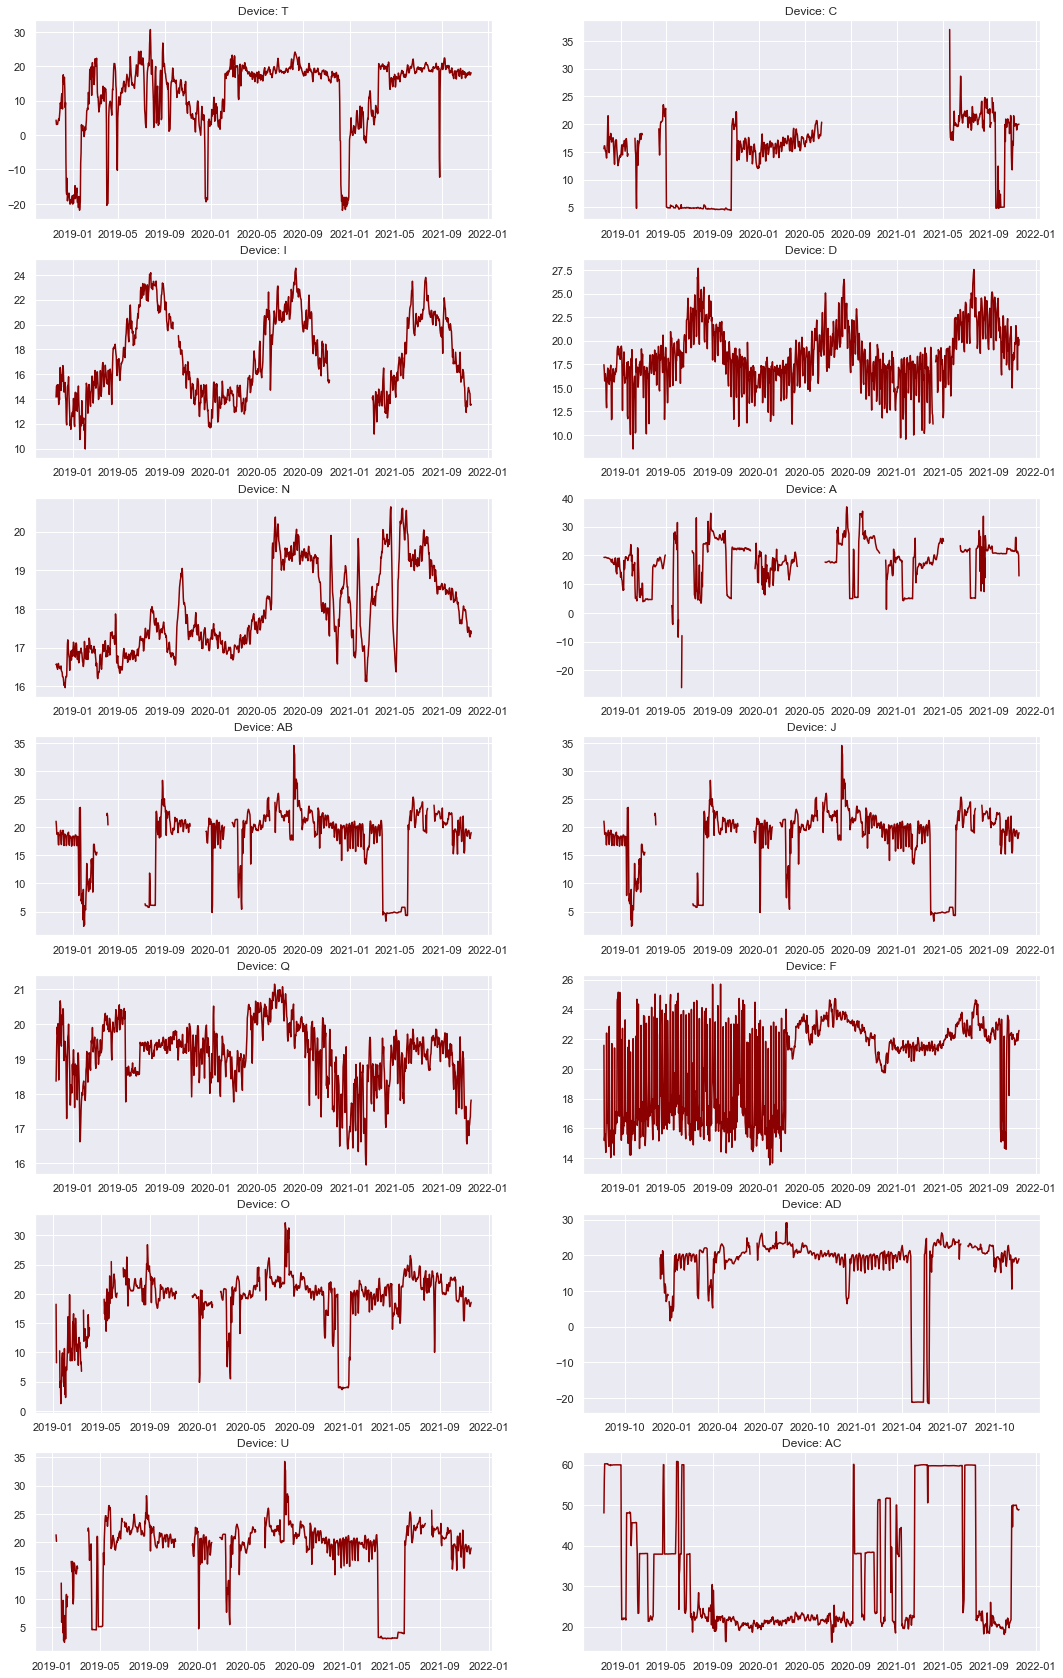

In [17]:
fig, axes = plt.subplots(7,2, figsize=(18,30))
axes[0,0].plot(df_t_daily["Temp"],color='darkred')
axes[0,1].plot(df_c_daily["Temp"],color='darkred')
axes[1,0].plot(df_i_daily["Temp"],color='darkred')
axes[1,1].plot(df_d_daily["Temp"],color='darkred')
axes[2,0].plot(df_n_daily["Temp"],color='darkred')
axes[2,1].plot(df_a_daily["Temp"],color='darkred')
axes[3,0].plot(df_ab_daily["Temp"],color='darkred')
axes[3,1].plot(df_j_daily["Temp"],color='darkred')
axes[4,0].plot(df_q_daily["Temp"],color='darkred')
axes[4,1].plot(df_f_daily["Temp"],color='darkred')
axes[5,0].plot(df_o_daily["Temp"],color='darkred')
axes[5,1].plot(df_ad_daily["Temp"],color='darkred')
axes[6,0].plot(df_u_daily["Temp"],color='darkred')
axes[6,1].plot(df_ac_daily["Temp"],color='darkred')
axes[0,0].set_title('Device: T')
axes[0,1].set_title('Device: C')
axes[1,0].set_title('Device: I')
axes[1,1].set_title('Device: D')
axes[2,0].set_title('Device: N')
axes[2,1].set_title('Device: A')
axes[3,0].set_title('Device: AB')
axes[3,1].set_title('Device: J')
axes[4,0].set_title('Device: Q')
axes[4,1].set_title('Device: F')
axes[5,0].set_title('Device: O')
axes[5,1].set_title('Device: AD')
axes[6,0].set_title('Device: U')
axes[6,1].set_title('Device: AC')
plt.show()

When it came to the pantry, it can be seen that the majority of the devices ended up in this group, which could be due to the scale range that we provided, but within a follow-up for the freezer and fridge, this part allowed us to see the pattern and provide additional limitations so that we could continue with our analysis phase.

# Further Analysis

After manually picking three datasets from each category we are ready to explore them and pick one for each category

## Freezers

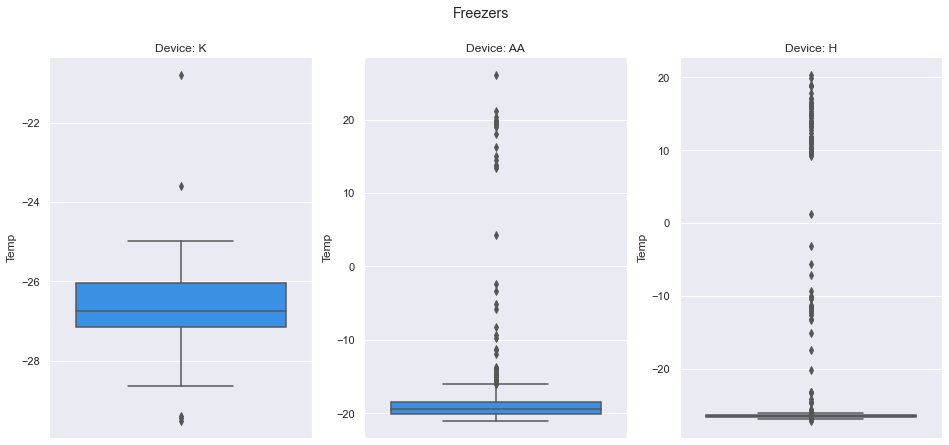

In [18]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Freezers')
sns.boxplot(ax=axes[0],y="Temp",data=df_k_daily,color='dodgerblue')
sns.boxplot(ax=axes[1],y="Temp",data=df_aa_daily,color='dodgerblue')
sns.boxplot(ax=axes[2],y="Temp",data=df_h_daily,color='dodgerblue')
axes[0].set_title('Device: K')
axes[1].set_title('Device: AA')
axes[2].set_title('Device: H')
plt.show()

Based on the results, we will choose **device K** since it has less outliers than devices AA and H, which can be easily spotted within a large number of them, slowing down our research and harming further modeling. As a consequence, we will continue to use device K for future study.

## Fridges

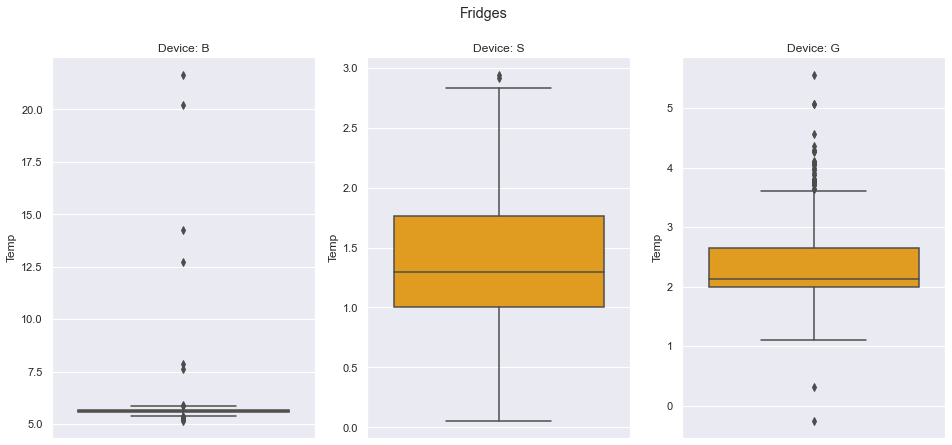

In [19]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Fridges')
sns.boxplot(ax=axes[0],y="Temp",data=df_b_daily,color='orange')
sns.boxplot(ax=axes[1],y="Temp",data=df_s_daily,color='orange')
sns.boxplot(ax=axes[2],y="Temp",data=df_g_daily,color='orange')
axes[0].set_title('Device: B')
axes[1].set_title('Device: S')
axes[2].set_title('Device: G')
plt.show()

In the case of the refrigerator, it is clear that **device B** will be eliminated due to its outliers, and that device G will be eliminated due to the outliers accumulating in the scale from 5 to 4 degrees. As a result, we will stick with device S, even though it contributed to a few of the outliers, because it is more useful for further research and modeling than the other two.

## Pantries

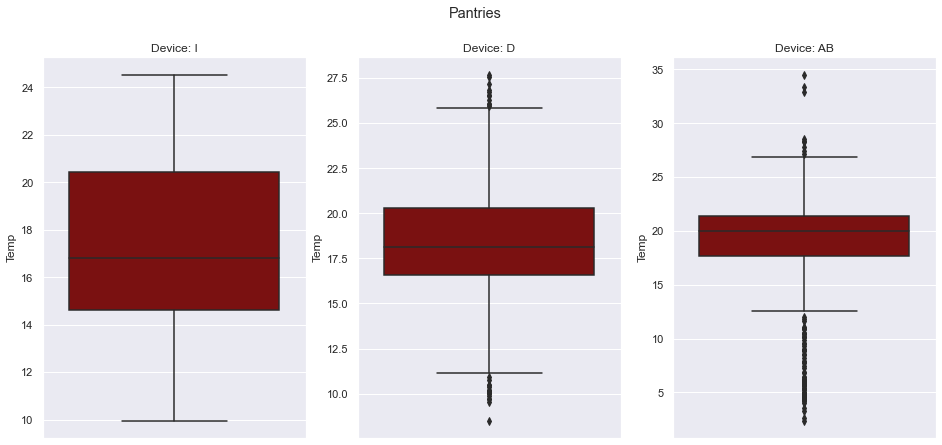

In [20]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Pantries')
sns.boxplot(ax=axes[0],y="Temp",data=df_i_daily,color='darkred')
sns.boxplot(ax=axes[1],y="Temp",data=df_d_daily,color='darkred')
sns.boxplot(ax=axes[2],y="Temp",data=df_ab_daily,color='darkred')
axes[0].set_title('Device: I')
axes[1].set_title('Device: D')
axes[2].set_title('Device: AB')
plt.show()

Following the same pattern as before, we will stick to **device I** as our main research recognition for the pantry category, based on the outliers in device D and AB. This is done with the idea that trained models with outliers will increase error variance and reduce the power of statistical tests for our modeling, so we approached to be sticking with device I.

## Selected Devices

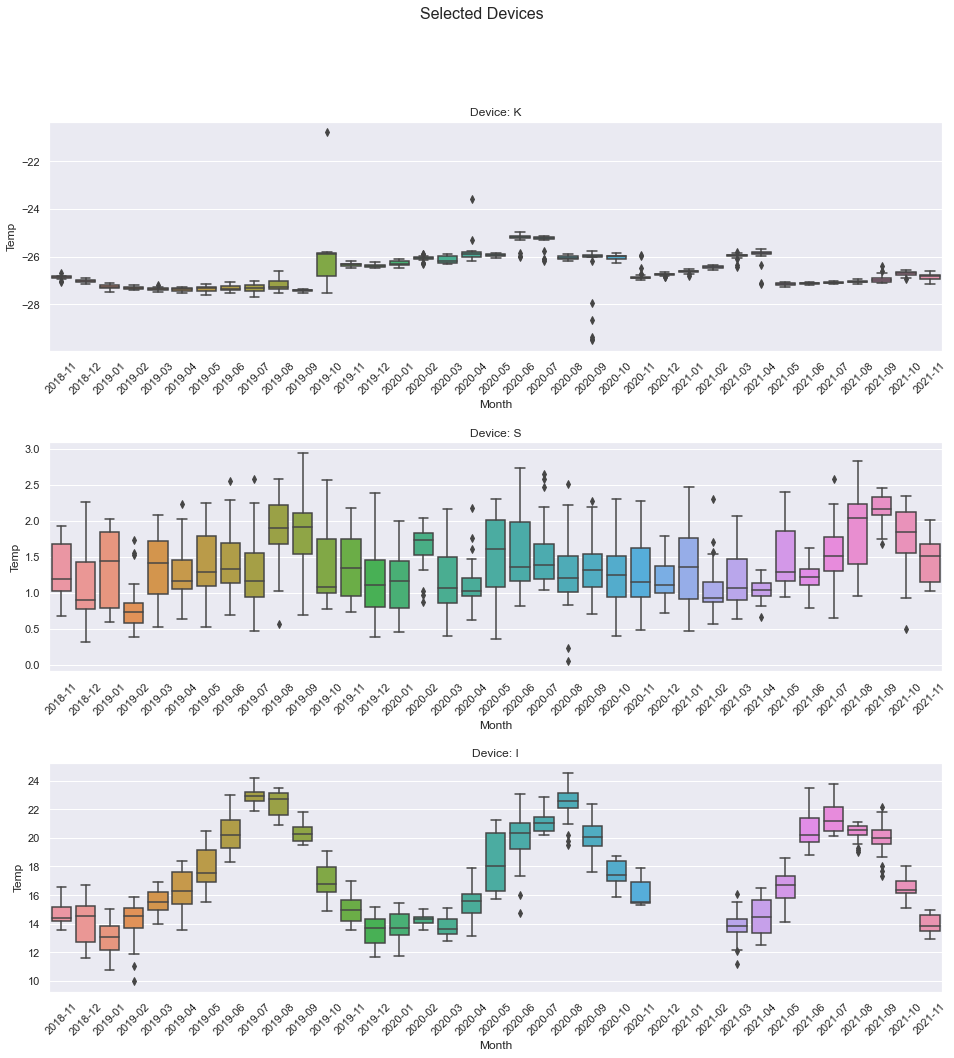

In [21]:
df_k_copy = df_k_daily.copy()
df_k_copy["Month"] = df_k_copy.index.to_period('M')

df_s_copy = df_s_daily.copy()
df_s_copy["Month"] = df_s_copy.index.to_period('M')

df_i_copy = df_i_daily.copy()
df_i_copy["Month"] = df_i_copy.index.to_period('M')

fig, axes = plt.subplots(3,1, figsize=(16,16))
plt.subplots_adjust(hspace=0.4)
fig.suptitle('Selected Devices', fontsize=16)
sns.boxplot(ax=axes[0],x="Month",y="Temp",data=df_k_copy)
sns.boxplot(ax=axes[1],x="Month",y="Temp",data=df_s_copy)
sns.boxplot(ax=axes[2],x="Month",y="Temp",data=df_i_copy)
axes[0].set_title('Device: K')
axes[1].set_title('Device: S')
axes[2].set_title('Device: I')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 45)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 45)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation = 45)
plt.show()

# Data Zoom in

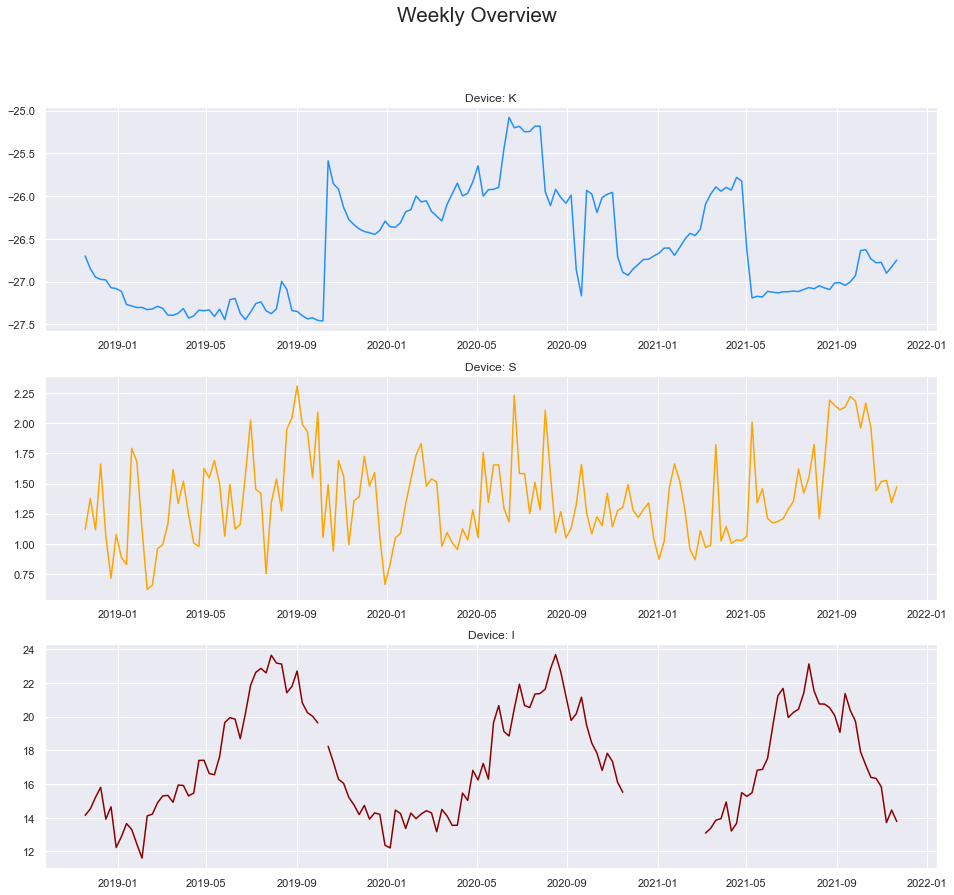

In [22]:
fig, axes = plt.subplots(3, figsize=(16,14))
fig.suptitle('Weekly Overview',fontsize="xx-large")
axes[0].plot(df_k_weekly,color='dodgerblue' )
axes[1].plot(df_s_weekly,color='orange')
axes[2].plot(df_i_weekly,color='darkred')
axes[0].set_title('Device: K')
axes[1].set_title('Device: S')
axes[2].set_title('Device: I')
plt.show()

## Hourly Zoom

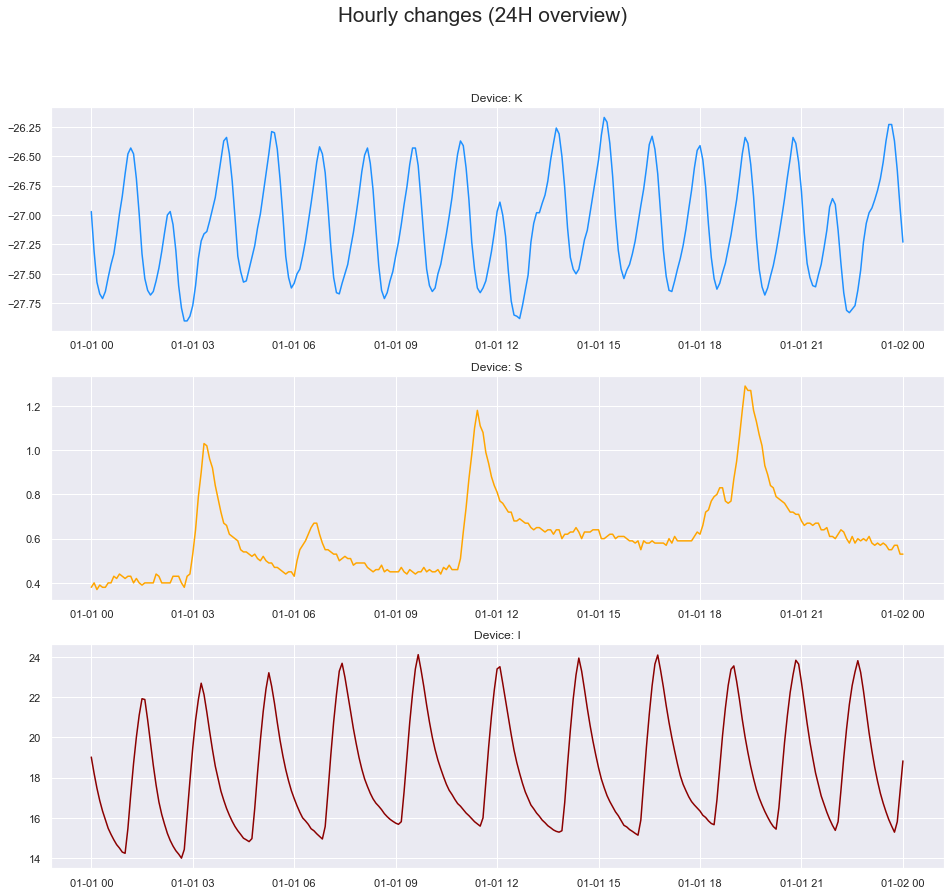

In [23]:
df_k_zoom = df_k.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]
df_s_zoom = df_s.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]
df_i_zoom = df_d.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]

fig, axes = plt.subplots(3, figsize=(16,14))
fig.suptitle('Hourly changes (24H overview)',fontsize="xx-large")
axes[0].plot(df_k_zoom,color='dodgerblue')
axes[1].plot(df_s_zoom,color='orange')
axes[2].plot(df_i_zoom,color='darkred')
axes[0].set_title('Device: K')
axes[1].set_title('Device: S')
axes[2].set_title('Device: I')
plt.show()

# Modeling

In [24]:
from neuralprophet import NeuralProphet

m = NeuralProphet()
# help(m)

In [25]:
df_i.T

EventDt,2018-11-18 16:35:00,2018-11-18 16:40:00,2018-11-18 16:45:00,2018-11-18 16:50:00,2018-11-18 16:55:00,2018-11-18 17:00:00,2018-11-18 17:05:00,2018-11-18 17:10:00,2018-11-18 17:15:00,2018-11-18 17:20:00,...,2021-11-18 15:45:00,2021-11-18 15:50:00,2021-11-18 15:55:00,2021-11-18 16:00:00,2021-11-18 16:05:00,2021-11-18 16:10:00,2021-11-18 16:15:00,2021-11-18 16:20:00,2021-11-18 16:25:00,2021-11-18 16:30:00
Temp,14.6,14.63,14.6,14.57,14.59,14.57,14.54,14.52,14.54,14.52,...,14.66,14.67,14.65,14.64,14.65,14.65,14.66,14.64,14.65,14.64


In [26]:
df_i["ds"] = df_i.index
df_i = df_i.rename(columns={"Temp": "y"})
df_i.T

EventDt,2018-11-18 16:35:00,2018-11-18 16:40:00,2018-11-18 16:45:00,2018-11-18 16:50:00,2018-11-18 16:55:00,2018-11-18 17:00:00,2018-11-18 17:05:00,2018-11-18 17:10:00,2018-11-18 17:15:00,2018-11-18 17:20:00,...,2021-11-18 15:45:00,2021-11-18 15:50:00,2021-11-18 15:55:00,2021-11-18 16:00:00,2021-11-18 16:05:00,2021-11-18 16:10:00,2021-11-18 16:15:00,2021-11-18 16:20:00,2021-11-18 16:25:00,2021-11-18 16:30:00
y,14.6,14.63,14.6,14.57,14.59,14.57,14.54,14.52,14.54,14.52,...,14.66,14.67,14.65,14.64,14.65,14.65,14.66,14.64,14.65,14.64
ds,2018-11-18 16:35:00,2018-11-18 16:40:00,2018-11-18 16:45:00,2018-11-18 16:50:00,2018-11-18 16:55:00,2018-11-18 17:00:00,2018-11-18 17:05:00,2018-11-18 17:10:00,2018-11-18 17:15:00,2018-11-18 17:20:00,...,2021-11-18 15:45:00,2021-11-18 15:50:00,2021-11-18 15:55:00,2021-11-18 16:00:00,2021-11-18 16:05:00,2021-11-18 16:10:00,2021-11-18 16:15:00,2021-11-18 16:20:00,2021-11-18 16:25:00,2021-11-18 16:30:00


In [27]:
df_i.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315648 entries, 2018-11-18 16:35:00 to 2021-11-18 16:30:00
Freq: 5T
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   y       278713 non-null  float64       
 1   ds      315648 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.2 MB


In [28]:
import warnings
warnings.filterwarnings('ignore')

m = NeuralProphet(yearly_seasonality=True,
#                   weekly_seasonality=False, 
#                   daily_seasonality=False,
                    epochs=30
                 )

metrics = m.fit(df_i, freq="D")
metrics

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 100.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T
INFO - (NP.forecaster.__handle_missing_data) - dropped 36935 NAN row in 'y'
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128


  0%|          | 0/372 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.02E-02, min: 1.52E+00


  0%|          | 0/372 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.02E-02, min: 1.79E+00


  0%|          | 0/372 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.02E-02, min: 1.90E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.02E-02
Epoch[30/30]: 100%|█████████████| 30/30 [01:47<00:00,  3.57s/it, SmoothL1Loss=0.00125, MAE=0.881, RMSE=1.14, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.873550,29.170217,34.321194,0.0
1,0.015445,2.829507,3.568443,0.0
2,0.001629,1.001956,1.302391,0.0
3,0.001646,1.017536,1.311111,0.0
4,0.001851,1.084213,1.390421,0.0
5,0.002102,1.159274,1.481037,0.0
6,0.002291,1.214910,1.546687,0.0
7,0.002475,1.264217,1.607427,0.0
8,0.002482,1.264532,1.609008,0.0
9,0.002486,1.266997,1.610894,0.0


In [29]:
future = m.make_future_dataframe(df_i, periods=365, n_historic_predictions=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 100.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.884% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.884% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T


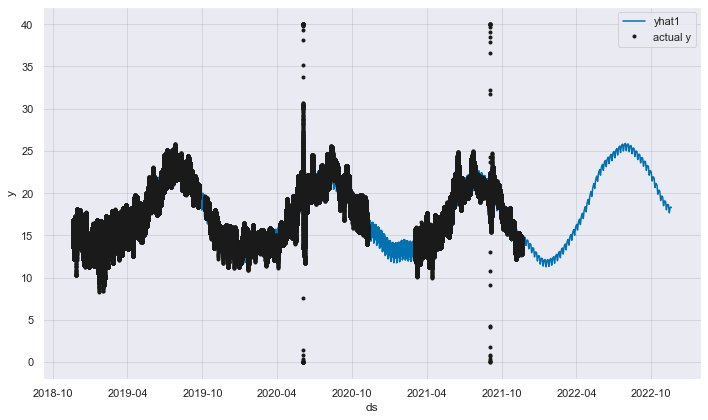

In [30]:
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [31]:
forecast

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,season_daily
0,2018-11-18 16:35:00,14.6,15.339241,0.739241,17.579149,-2.441790,-0.554113,0.755995
1,2018-11-18 16:40:00,14.63,15.338912,0.708912,17.579241,-2.441965,-0.553699,0.755336
2,2018-11-18 16:45:00,14.6,15.338252,0.738252,17.579332,-2.442141,-0.553274,0.754335
3,2018-11-18 16:50:00,14.57,15.337234,0.767234,17.579424,-2.442317,-0.552839,0.752967
4,2018-11-18 16:55:00,14.59,15.335836,0.745836,17.579515,-2.442492,-0.552393,0.751206
...,...,...,...,...,...,...,...,...
316008,2022-11-14 16:30:00,None,17.980213,NaN,19.645267,-2.235983,-0.185410,0.756338
316009,2022-11-15 16:30:00,None,18.258856,NaN,19.653992,-2.288348,0.136873,0.756338
316010,2022-11-16 16:30:00,None,18.334002,NaN,19.662718,-2.339926,0.254871,0.756338
316011,2022-11-17 16:30:00,None,18.309280,NaN,19.671444,-2.390940,0.272439,0.756338


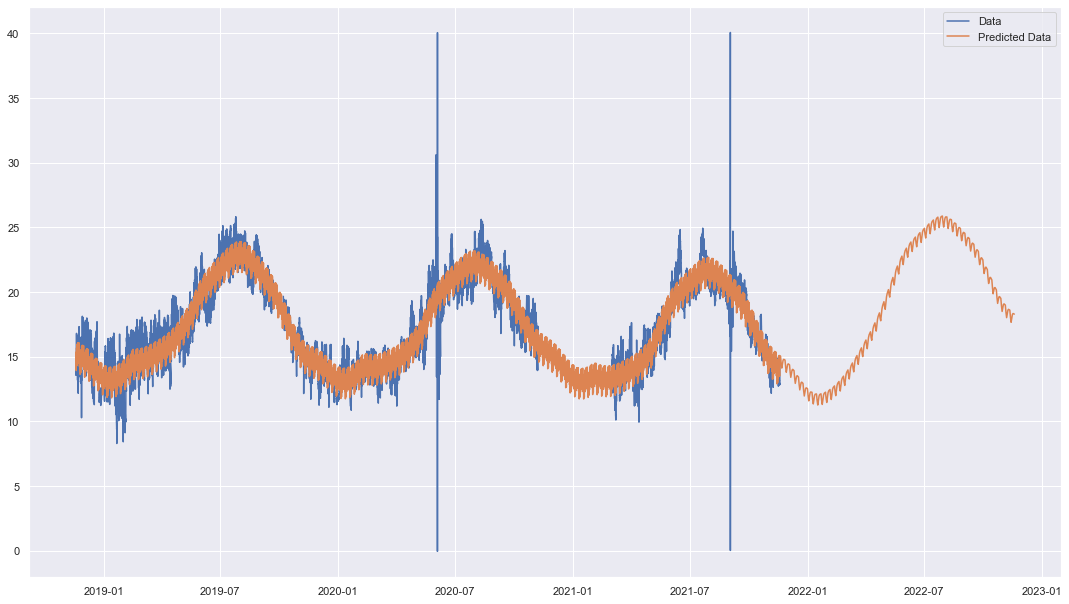

In [32]:
fig, ax = plt.subplots()
ax.plot(forecast["ds"],forecast["y"], label="Data")
ax.plot(forecast["ds"],forecast["yhat1"],label="Predicted Data")
ax.legend(loc = 'upper right')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

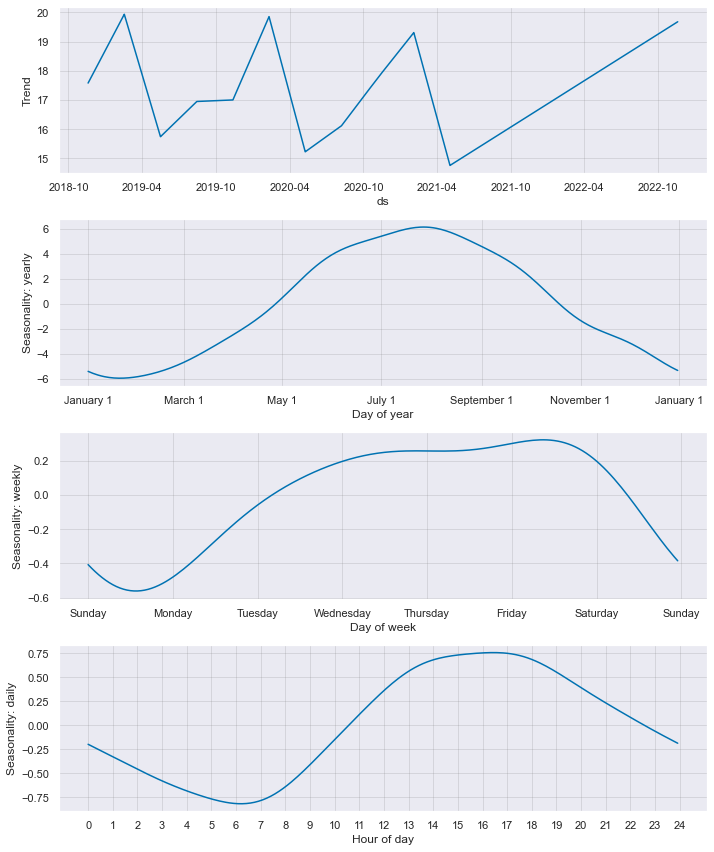

In [33]:
fig2 = m.plot_components(forecast)

In [34]:
## https://neuralprophet.com/html/test_and_crossvalidate.html
## Need to add crossvalidation